<a href="https://colab.research.google.com/github/royal-dit/tensorflow-deeplearning/blob/main/bitcoin%20price%20prediction/Bitcoin_price_predictor_part_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
 import pandas as pd
 import numpy as np
 import matplotlib.pyplot as plt
 from sklearn.preprocessing import MinMaxScaler
 from tensorflow.keras.layers import Dense,Dropout,LSTM
 from tensorflow.keras.models import Sequential
 import requests
 import tensorflow as tf


In [43]:
! wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv


--2022-11-05 06:48:03--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.003s  

2022-11-05 06:48:04 (66.6 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1’ saved [178509/178509]



In [44]:
df=pd.read_csv('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv',parse_dates=['Date'],index_col=['Date'])
df.head(2)

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383


In [45]:
#only want closing price for each day
bitcoin_prices = pd.DataFrame(df['Closing Price (USD)']).rename(columns={'Closing Price (USD)':"Price"})
bitcoin_prices.head()


,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [46]:
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()
timesteps[:5],prices[:5]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000'], dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866]))

In [47]:
HORIZON=1
WINDOW_SIZE =7


#model 7 N-BEATS
**neural basis expansion analysis for interpretable time seris forecastin**

In [48]:
#create nbeat custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size:int,
               theta_size:int,
               horizon :int,
               n_neurons:int,
               n_layers:int,
               **kwargs ):#take care of all of the arguments for the parent class(input_shape,trainable,name)
              
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size =  theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers
    #blocks contains stack of 4 fully connected layers each has relu 
    self.hidden = [tf.keras.layers.Dense(n_neurons,activation = 'relu')for _ in range(n_layers)]
    #output of the block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size,activation = 'linear',name='theta')
  
  def call(self,inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    #output the backcast and forecast from theta
    backcast ,forecast = theta[:,:self.input_size],theta[:,-self.horizon]
    return backcast,forecast

In [49]:
#lets create dummy inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size = WINDOW_SIZE,
                                       theta_size = WINDOW_SIZE + HORIZON,
                                       horizon = HORIZON,
                                       n_neurons = 128,
                                       n_layers = 4
                                       
                                       )

In [50]:
#create the dummy  inputs
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE)+1,axis = 0)# input shape to the model has to reflect layer input req(ndim = 2)
dummy_inputs


<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [51]:
#pass dummy inputs to dummy NBeatsBlock layer
backcast,forecast = dummy_nbeats_block_layer(dummy_inputs)
#these are just the activation output of the thet layer
print(f"Backcast:{tf.squeeze(backcast.numpy())}")
print(f"Forecast:{tf.squeeze(forecast.numpy())}")




Backcast:[-0.99214196 -0.70515704  0.28788796  0.75638974  0.42981252 -0.48059064
 -0.66622865]
Forecast:-0.7228370904922485


**preperaing nbeats algorithm using tf.data**

In [52]:
HORIZON = 1
WINDOW_SIZE =7

In [53]:
#create nbeat data inputs (nbeats work with univariate)
bitcoin_prices.head(2)

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500


In [54]:
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.head(4)


,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN


In [55]:
X = bitcoin_prices_nbeats.dropna().drop("Price",axis=1)
y=bitcoin_prices_nbeats.dropna()["Price"]

#make train and test set
split_size = int(len(X)*0.8)
X_train,y_train = X[:split_size],y[:split_size]
X_test ,y_test = X[split_size:],y[split_size:]
len(X_train),len(y_train),len(X_test),len(y_test)

(2224, 2224, 556, 556)

In [56]:
#time to make our datset perfomant using tf.data.API
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)
test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

#combine labels and features by zippin together 
train_dataset = tf.data.Dataset.zip((train_features_dataset,train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset,test_labels_dataset))

#batch and prefetch 
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset,test_dataset





(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

**setting up hyperparameter for nbeats algorithm**

In [57]:
#values from N BEATS paper
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30
INPUT_SIZE  = 7
THETA_SIZE = INPUT_SIZE + HORIZON



**Getting ready for residual connections**

In [58]:
#demo
tensor_1 = tf.range(10)+10
tensor_2 = tf.range(10)

#subtract
subtracted = tf.keras.layers.subtract([tensor_1,tensor_2])

#ADD
added = tf.keras.layers.add([tensor_1,tensor_2])

#get output 
print(f"input tensor: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"subtracted:{subtracted.numpy()}")
print(f"added:{added.numpy()}")

input tensor: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
subtracted:[10 10 10 10 10 10 10 10 10 10]
added:[10 12 14 16 18 20 22 24 26 28]


**building compiling and fitting algorithms**

In [59]:
%%time

tf.random.set_seed(42)
#set up the instance for nbeatsblock
nbeats_block_layer = NBeatsBlock(input_size = INPUT_SIZE,
                                 theta_size = THETA_SIZE,
                                 horizon = HORIZON,
                                 n_neurons = N_NEURONS,
                                 n_layers = N_LAYERS,
                                 name = "InitialBlock")

#2. create input to stack 
stack_input = tf.keras.layers.Input(shape = (INPUT_SIZE),name = "stack_input")

#3. initail back cast and forecast input (backward prdicition + horizon prediction) 
residuals,forecast = nbeats_block_layer(stack_input)

#4. create a stacks of block layers 
for i ,_ in enumerate(range(N_STACKS-1)): # first satck is already creasted in (3)

#5.use nbeats block to calculate the backcast as well as forecast 
 backcast, block_forecast  = NBeatsBlock(
    input_size = INPUT_SIZE,
    theta_size = THETA_SIZE,
    horizon = HORIZON,
    n_neurons = N_NEURONS,
    n_layers = N_LAYERS,
    name = f"NBeatsBlock_{i}")(residuals) # pass the residuals

#6. create the double residual stacking 
 residuals = tf.keras.layers.subtract([residuals,backcast],name = f"subtract_{i}")
 forecast = tf.keras.layers.add([forecast,block_forecast],name = f"add_{i}")

#7 put the stack model together 

                                 

CPU times: user 1.32 s, sys: 30.2 ms, total: 1.35 s
Wall time: 1.36 s


In [60]:
stack_input,forecast,train_dataset

(<KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'stack_input')>,
 <KerasTensor: shape=(None,) dtype=float32 (created by layer 'add_28')>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [61]:
#7. put the stack model together
model_7 = tf.keras.Model(inputs = stack_input,outputs = forecast,name="model_7_NBEATS")

#8. compile model with mae loss 
model_7.compile(loss = "mae",
                optimizer = tf.keras.optimizers.Adam()
                )
#9.fit the model with early stopping and reduce LROnPlateau callbacks
model_7.fit(train_dataset,
            epochs = N_EPOCHS,
            validation_data  = test_dataset,
            verbose = 0,
            callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                          patience = 200,
                                                          restore_best_weights = True),
                         tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",                         
                                                              patience = 100,
                                                              verbose = 1 )
                                                          ])
                                                              
                                           


Epoch 754: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 1256: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1356: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.


In [62]:
model_7.evaluate(test_dataset)


1/1 [==============================] - 0s 21ms/step - loss: 569.9474


569.9473876953125

In [63]:
#making forecast model
def make_preds(model,test_data):
  model = model.predict(test_data) 
  return tf.squeeze(model)

In [64]:
#make prediction with nbeats model
model_7_preds = make_preds(model_7,test_dataset)
model_7_preds[:10]

1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8834.906, 8783.763, 9051.662, 8760.866, 8752.862, 8757.246,
       8667.624, 8500.359, 8483.462, 8527.059], dtype=float32)>

In [65]:
def mean_absolute_scaled_error(y_true,y_pred):
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))
  mae_naive_no_season=tf.reduce_mean(tf.abs(y_true[1:]-y_true[:-1]))
  return mae/mae_naive_no_season

def evaluate_preds(y_true,y_pred):
  #make sure floar32 datatype
  y_true = tf.cast(y_true,dtype = tf.float32)
  y_pred = tf.cast(y_pred,dtype = tf.float32)

  #calcuate the various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true,y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true,y_pred)
  rmse =tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true,y_pred)
  mase=mean_absolute_scaled_error(y_true,y_pred)

  #account for diff size metrics
  if mae.ndim >0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase= tf.reduce_mean(mase)

  return{"mae":mae.numpy(),
          "mse":mse.numpy(),
          "rmse": rmse.numpy(),
          "mape":mape.numpy(),
           "mase":mase.numpy() }

In [66]:
model_7_results = evaluate_preds(y_true = y_test,
                                 y_pred = model_7_preds)
model_7_results

{'mae': 569.9474,
 'mse': 1155081.0,
 'rmse': 1074.747,
 'mape': 2.5687747,
 'mase': 1.0012397}

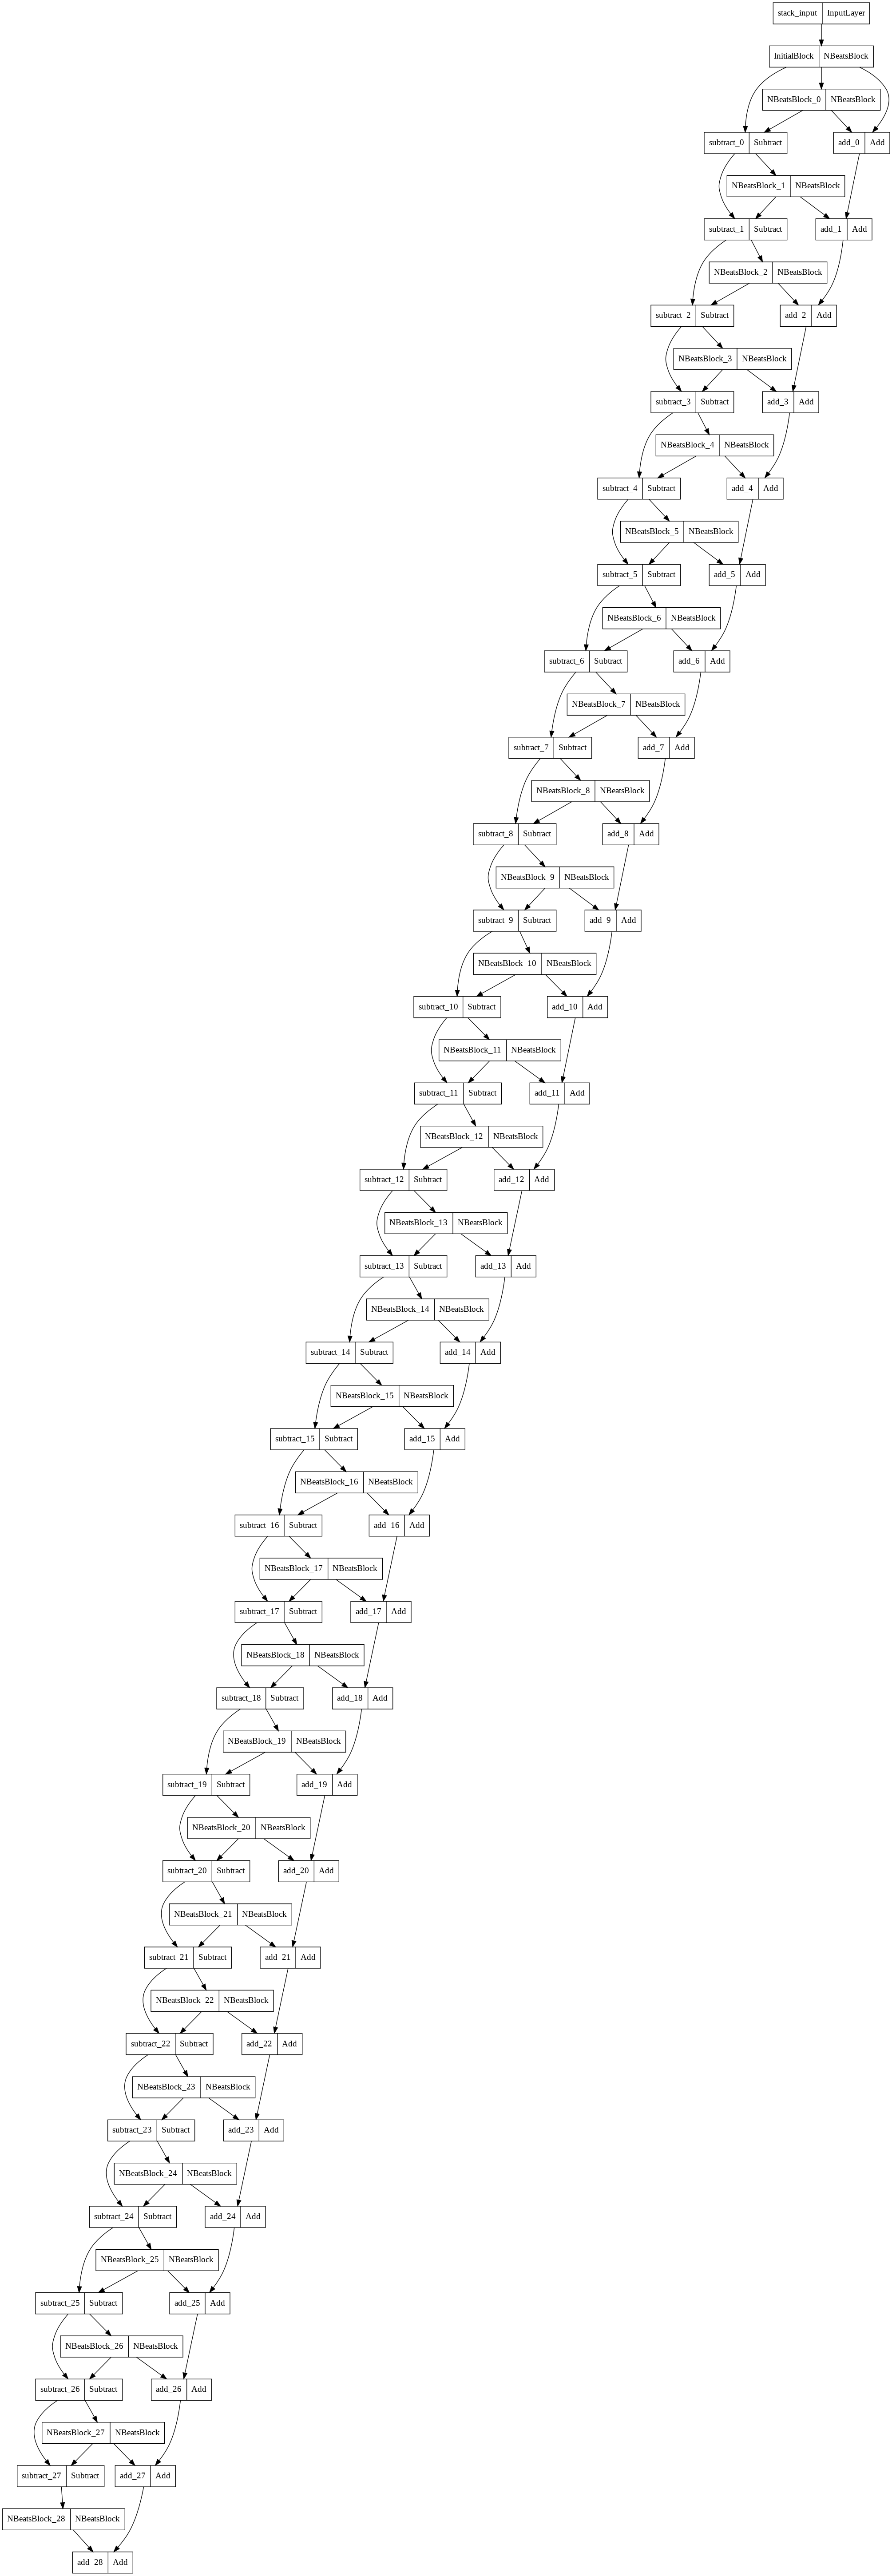

In [67]:
#plotting the nbeats archetecture 
from tensorflow.keras.utils import plot_model
plot_model(model_7)



#Model 8 ENSEMBLE MODEL (Stacking diffirent models together)

In [68]:
#make a empty list for trained ensembled models
ensemble_models = []
def get_ensemble_models(horizon = HORIZON,\
                        train_data = train_dataset,
                        test_data = test_dataset,
                        num_iter = 10,
                        num_epochs = 1000,
                        loss_fn = ["mae","mse","mape"]):
  
    
  """
  returns a list of num_iter_model each trained on mae mse mape
  for ex if num_iter = 10 a list of 30 trained models will be returned
  """
  #create num_iter number model per loss function
  for i in range(num_iter):
    #build and fit a new model with a diff loss
    for loss_function in loss_fn:
      print(f"Optimizing model by reducing:{loss_function} for {num_epochs} epochs,model number:{i}")
      #construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
          tf.keras.layers.Dense(128,kernel_initializer = "he_normal",activation = 'relu'),
          tf.keras.layers.Dense(128,kernel_initializer = "he_normal",activation ='relu'),
          tf.keras.layers.Dense(HORIZON)
      ])
      #compile simple model with current losee function
      model.compile(loss = loss_function,
                    optimizer = 'adam',
                    metrics = ["mae","mse"]
                    )
     #fit the model
      model.fit(train_data,
               epochs = num_epochs,
               verbose = 0,
               validation_data = test_data,
               callbacks = [tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
                                                             patience = 200,
                                                             restore_best_weights = True
                                                             
                                                             ),
                            tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",
                                                                 patience = 100,
                                                                 verbose = 1
                                                                 )
                            ])
      #appended the fitted model to a list of ensemble
      ensemble_models.append(model)
    
  return ensemble_models          
               




In [ ]:
%%time
ensemble_models = get_ensemble_models(num_iter = 5,
                                      num_epochs = 1000
                                      )

Optimizing model by reducing:mae for 1000 epochs,model number:0

Epoch 900: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing:mse for 1000 epochs,model number:0

Epoch 501: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing:mape for 1000 epochs,model number:0

Epoch 168: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.


**make prediction using ensemble model**

In [ ]:
def make_ensemble_preds(ensemble_models,data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))
  


In [ ]:
#create a list of ensemble prediction
%%time 
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data = test_dataset)
ensemble_preds
                                     

In [ ]:
#using mean
ensemble_mean = tf.reduce_mean(ensemble_preds,axis = 0)
ensemble_mean[:10]


In [ ]:
ensemble_median = np.median(ensemble_preds,axis =0)
ensemble_median[:10]

In [ ]:
ensemble_results = evaluate_preds(y_true=y_test,y_pred = ensemble_preds)
ensemble_results

In [ ]:
ensemble_results = evaluate_preds(y_true=y_test,y_pred = ensemble_mean)
ensemble_results

In [ ]:
ensemble_results = evaluate_preds(y_true=y_test,y_pred = ensemble_median)
ensemble_results

In [ ]:
 # find the upper and lower bouds of ensemble prediction
def get_upper_lower(preds):   # takes the prediciton of a number o randomly intailized
     #measur the standard deviation of 
     std = tf.math.reduce_std(preds,axis=0)
     #multiply the standard deviation by 1.96
     interval = 1.96*std

     #get the prediction interval upper and lower bounds
     preds_mean = tf.reduce_mean(preds,axis = 0)
     lower,upper = preds_mean-interval,preds_mean+interval

     return lower, upper





In [ ]:
#get the upper and lower bounds of 95% prediction interval
lower,upper  = get_upper_lower(preds = ensemble_preds)
lower,upper

In [ ]:
#get the median/mean values of our ensemble preds
ensemble_median = np.median(ensemble_preds,axis=0)
#plot the median of our ensemble preds along with the prediciton interavas
offset = 500
plt.figure(figsize=(10,7))
plt.plot(X_test.index[offset:],y_test[offset:],"g",label = "Test data")
plt.plot(X_test.index[offset:],ensemble_median[offset:],"k-",label="Ensemble median")
plt.xlabel("Data")
plt.ylabel("Btc Price")
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:],label="Prediciton Intervals"
                 )
plt.legend(loc = "upper left",fontsize = 14)
